## 폐암 판별
- 15000개 폐 조직의 이미지 (768x768 픽셀)
    * 정상 (normal) : 5000
    * 폐 선암종 (adenocarcinoma) : 5000
    * 폐 편평 세포 암종 (squamous cell carcinoma) : 5000

In [1]:
import os
import glob
import random
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from PIL import Image

### 15000개 데이터 split
* train : 12000
* val : 3000
* test : 3000

In [2]:
data_dir = '../../datasets/lung_image_sets/'

In [3]:
# 이미지 파일경로와 폴더명(클래스) 리스트로 반환
def define_paths(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

# define_paths에서 반환한 파일경로와 클래스 데이터 프레임화
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# tran, test, validation으로 split
def create_df(data_dir):
   
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    
    strat=df['labels']
    train_df, dummy_df=train_test_split(df,  train_size=0.8, shuffle=True, random_state=123, stratify=strat)
    
    strat = dummy_df['labels']
    valid_df, test_df=train_test_split(dummy_df,  train_size=0.5, shuffle=True, random_state=123, stratify=strat)
    return train_df, valid_df, test_df

In [4]:
train_df, valid_df, test_df = create_df(data_dir)

In [6]:
batch_size = 40
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
def scalar(img):
    return img
tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)
valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


### EfficientNetB3 모델 기반 전이학습
    - EfficientNetB3는 Google에서 개발한 컨볼루션 신경망(Convolutional Neural Network) 모델 중 하나로, 총 25개의 레이어로 구성되어 있습니다.

    - EfficientNetB3는 기본적으로 Depthwise Separable Convolution을 기반으로 하는 MobileNet과 같은 구조를 가지고 있지만, Convolutional Layer, Depthwise Separable Convolution, Swish Activation Function, Batch Normalization, Dropout, Global Average Pooling 등 다양한 레이어를 사용하여 구성됩니다. 또한, EfficientNetB3는 네트워크 깊이와 너비, 해상도를 동시에 확장하는 Compound Scaling 기법을 사용하여 성능을 최적화합니다.

In [44]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", # ImageNet 데이터셋에서 학습된 가중치를 사용
                                                                input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_1 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 11,183,922
Trainable params: 11,093,547
Non-trainable params: 90,375
_____________________________________

#### 학습

In [45]:
batch_size = 128
hist = model.fit(train_gen,
                 steps_per_epoch=train_gen.samples//batch_size,
                 validation_data=valid_gen,
                 validation_steps=valid_gen.samples//batch_size,
                 epochs=3)

Epoch 1/3
93/93 [==============================] - 1073s 11s/step - loss: 6.4357 - accuracy: 0.9151 - val_loss: 5.0453 - val_accuracy: 0.9750
Epoch 2/3
93/93 [==============================] - 1446s 16s/step - loss: 4.0309 - accuracy: 0.9691 - val_loss: 3.3948 - val_accuracy: 0.9795
Epoch 3/3
93/93 [==============================] - 977s 10s/step - loss: 2.7905 - accuracy: 0.9804 - val_loss: 2.3137 - val_accuracy: 0.9977


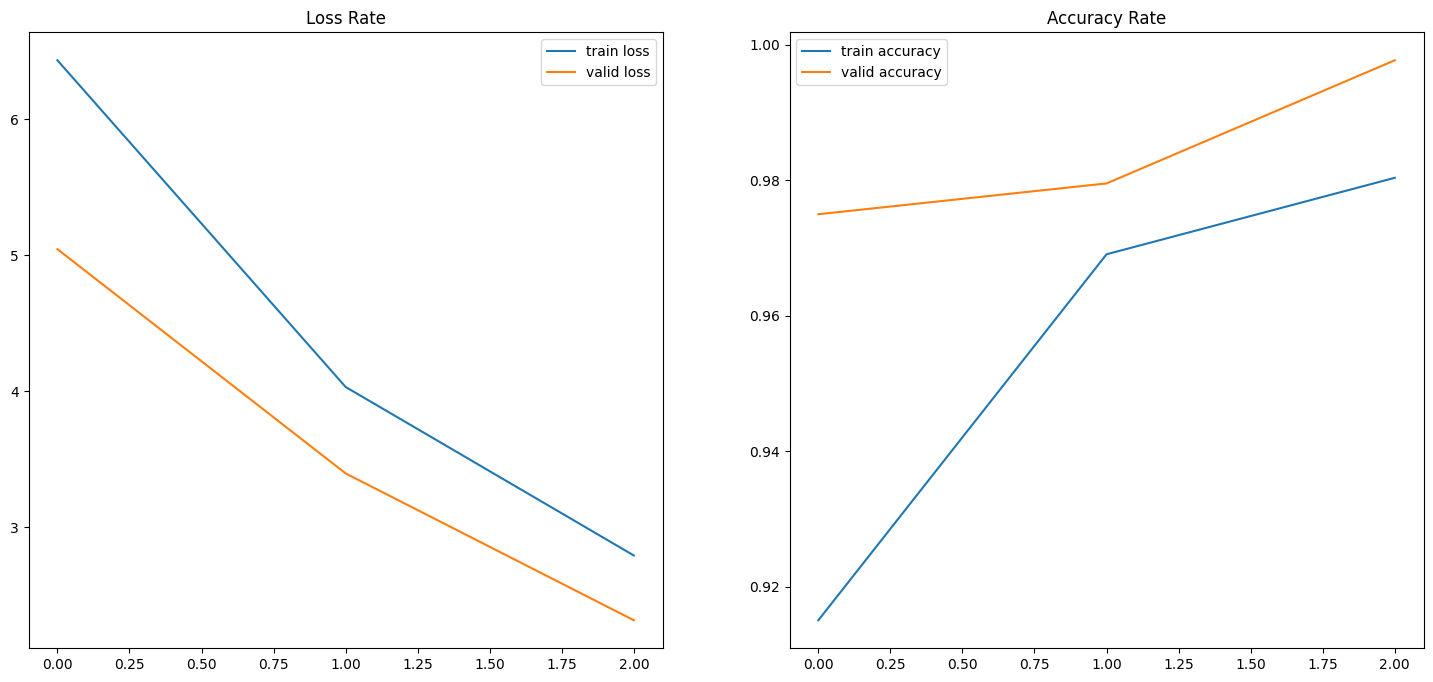

In [49]:
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'],label='train loss')
plt.plot(hist.history['val_loss'],label='valid loss')
plt.title('Loss Rate')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'],label='train accuracy')
plt.plot(hist.history['val_accuracy'],label='valid accuracy')
plt.title('Accuracy Rate')
plt.legend()

plt.show()

#### test 데이터 예측

In [46]:
batch_size = 100
target_names = ['adenocarcinoma', 'normal', 'squamous cell carcinoma']
Y_pred = model.predict_generator(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

C:\Users\LG\AppData\Local\Temp\ipykernel_17028\3069543947.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_gen)


[0 1 1 ... 2 1 0]


#### 혼돈행렬

In [47]:
cm = confusion_matrix(test_gen.classes, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap = plt.cm.Blues):
  plt.figure(figsize=(10, 10))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized Confusion Matrix')
  else:
    print('Confusion Matrix, Without Normalization')
  
  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color = 'white' if cm[i, j] > thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[493   2   5]
 [  0 500   0]
 [  0   0 500]]


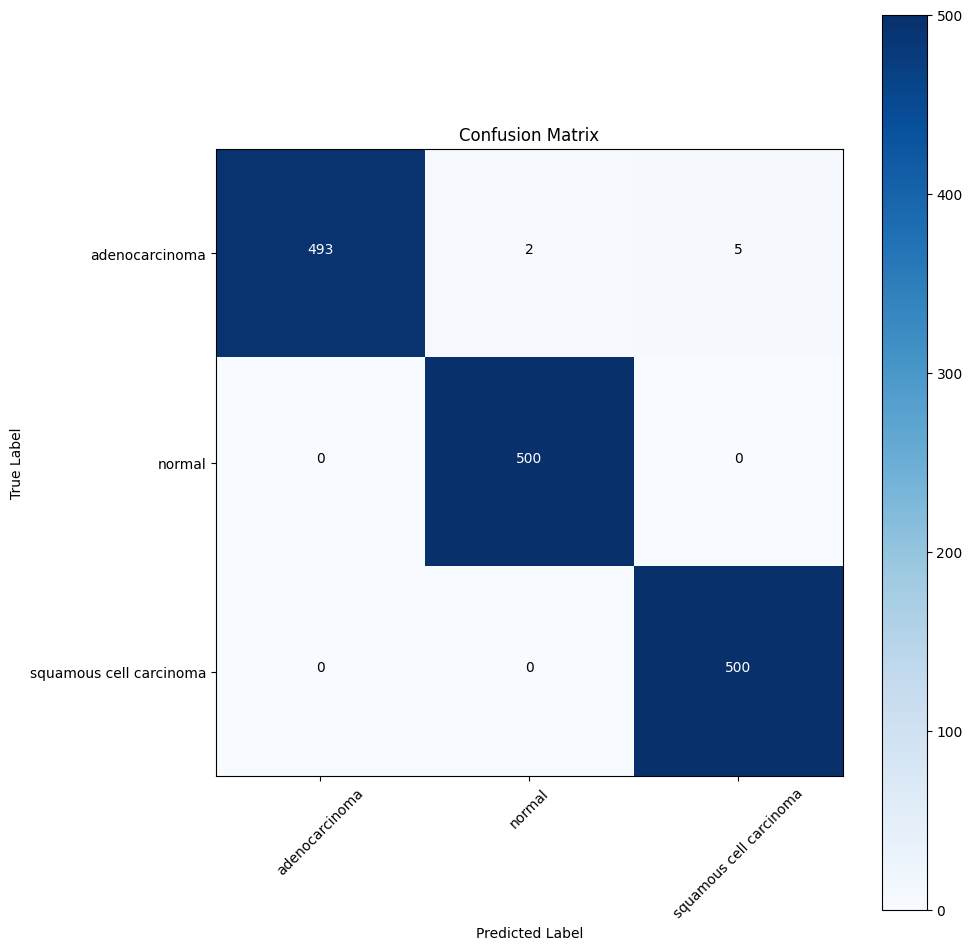

In [48]:
plot_confusion_matrix(cm=cm, classes=target_names, title = 'Confusion Matrix')

#### 모델 저장

In [50]:
model.save('Efficientb3-Lung_Cancer.h5')

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

#### 외부 이미지로 예측

폐 편평 세포 암종 (squamous cell carcinoma)

In [84]:
image_path = '../../datasets/test/squamous cell carcinoma.jpg'
image = Image.open(image_path)
new_size = (224, 224)
resized_image = image.resize(new_size)
rgb_image = resized_image.convert('RGB')
image_array = np.asarray(rgb_image)
image_array = np.expand_dims(image_array, axis=0)

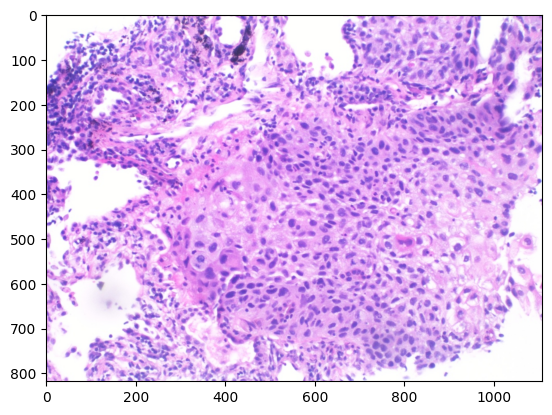

In [85]:
plt.imshow(image)

In [86]:
image_array.shape

(1, 224, 224, 3)

In [87]:
# ['adenocarcinoma', 'normal', 'squamous cell carcinoma']
model.predict(image_array)

1/1 [==============================] - 0s 98ms/step


array([[0.01603794, 0.01176615, 0.9721959 ]], dtype=float32)

0.9721으로 매우 정확하게 예측함

#### 비슷하게 생긴거 생각나서

In [88]:
image_path = '../../datasets/test/용과.png'
image = Image.open(image_path)
new_size = (224, 224)
resized_image = image.resize(new_size)
rgb_image = resized_image.convert('RGB')
image_array = np.asarray(rgb_image)
image_array = np.expand_dims(image_array, axis=0)

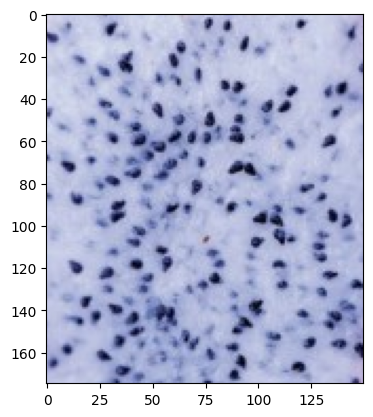

In [89]:
plt.imshow(image)

In [90]:
# ['adenocarcinoma', 'normal', 'squamous cell carcinoma']
model.predict(image_array)87ㅛ

1/1 [==============================] - 0s 113ms/step


array([[0.19970556, 0.30074266, 0.4995518 ]], dtype=float32)

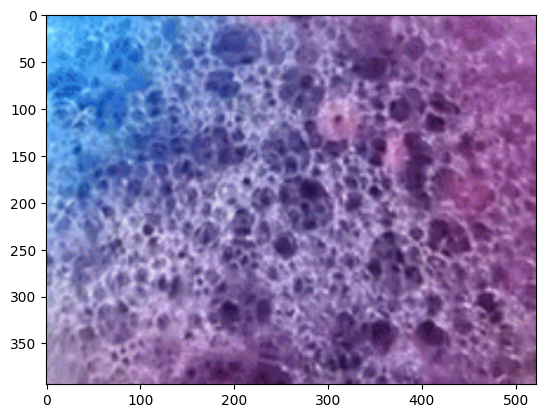

In [91]:
image_path = '../../datasets/test/액괴.png'
image = Image.open(image_path)
new_size = (224, 224)
resized_image = image.resize(new_size)
rgb_image = resized_image.convert('RGB')
image_array = np.asarray(rgb_image)
image_array = np.expand_dims(image_array, axis=0)
plt.imshow(image)

In [92]:
# ['adenocarcinoma', 'normal', 'squamous cell carcinoma']
model.predict(image_array)

1/1 [==============================] - 0s 173ms/step


array([[0.01290158, 0.00759701, 0.9795014 ]], dtype=float32)

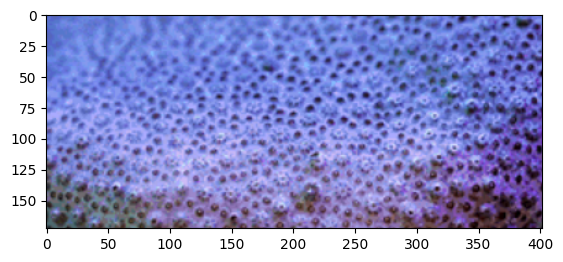

In [93]:
image_path = '../../datasets/test/산호초.png'
image = Image.open(image_path)
new_size = (224, 224)
resized_image = image.resize(new_size)
rgb_image = resized_image.convert('RGB')
image_array = np.asarray(rgb_image)
image_array = np.expand_dims(image_array, axis=0)
plt.imshow(image)

In [94]:
# ['adenocarcinoma', 'normal', 'squamous cell carcinoma']
model.predict(image_array)

1/1 [==============================] - 0s 133ms/step


array([[0.0978326 , 0.02338457, 0.87878287]], dtype=float32)

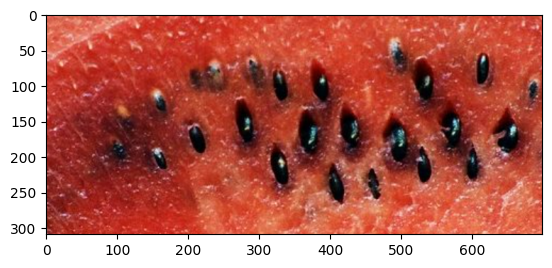

In [95]:
image_path = '../../datasets/test/수박.png'
image = Image.open(image_path)
new_size = (224, 224)
resized_image = image.resize(new_size)
rgb_image = resized_image.convert('RGB')
image_array = np.asarray(rgb_image)
image_array = np.expand_dims(image_array, axis=0)
plt.imshow(image)

In [96]:
# ['adenocarcinoma', 'normal', 'squamous cell carcinoma']
model.predict(image_array)

1/1 [==============================] - 0s 124ms/step


array([[0.01910371, 0.01058337, 0.9703129 ]], dtype=float32)